In [47]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

algo1 = pd.read_csv('results/algo1.csv')
algo2 = pd.read_csv('results/algo2.csv')
optsol = pd.read_csv('results/optsol.csv')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth', None)

In [48]:
results = pd.merge(algo1, algo2, how='outer')
results = pd.merge(results, optsol, how='outer')

In [49]:
results['input_size'] = results['input'].map(lambda x: x.count('-') + 1)
results['vertex_count'] = results['input'].map(lambda x: x.split('-')[0].count(',') + 1)

keywords = ['algo1', 'algo2', 'optsol']
for keyword in keywords:
    results[f'num_rel_{keyword}'] = results[f'output_{keyword}'].map(lambda x: x.count('('))
    if keyword != 'optsol':
        results[f'approx_{keyword}'] = results.apply(lambda x: x[f'cost_{keyword}']/x[f'cost_optsol'], axis=1)
        results[f'cost_diff_{keyword}'] = results.apply(lambda x: abs(x[f'cost_{keyword}'] - x[f'cost_optsol']), axis=1)

print(results.shape)
results.describe()

(2212, 18)


,cost_algo1,runtime_algo1,cost_algo2,runtime_algo2,cost_optsol,input_size,vertex_count,num_rel_algo1,approx_algo1,cost_diff_algo1,num_rel_algo2,approx_algo2,cost_diff_algo2,num_rel_optsol
count,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000
mean,6.867993,0.000465,14.522152,0.000662,4.836799,11.750452,3.971519,22.089060,1.407256,2.032098,74.110307,2.917041,9.685353,23.031193
std,2.831101,0.000419,9.328759,0.000972,1.553229,6.307019,0.166380,9.214845,0.434834,2.014951,44.493466,1.822529,8.705987,8.717716
min,1.000000,0.000034,1.000000,0.000023,1.000000,1.000000,3.000000,2.000000,0.875000,0.000000,3.000000,1.000000,0.000000,0.000000
25%,5.000000,0.000161,6.000000,0.000147,4.000000,6.000000,4.000000,15.000000,1.000000,0.000000,35.000000,1.500000,2.000000,18.000000
50%,7.000000,0.000447,13.000000,0.000383,5.000000,12.000000,4.000000,24.000000,1.285714,1.000000,70.000000,2.333333,7.000000,23.000000
75%,9.000000,0.000656,22.000000,0.001016,6.000000,17.000000,4.000000,30.000000,1.666667,4.000000,111.000000,4.000000,16.000000,29.000000
max,12.000000,0.007915,37.000000,0.030236,9.000000,24.000000,4.000000,39.000000,3.000000,8.000000,174.000000,9.250000,33.000000,53.000000


<AxesSubplot:xlabel='input_size', ylabel='runtime_algo2'>

<Figure size 432x288 with 0 Axes>

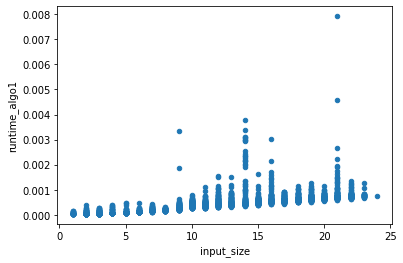

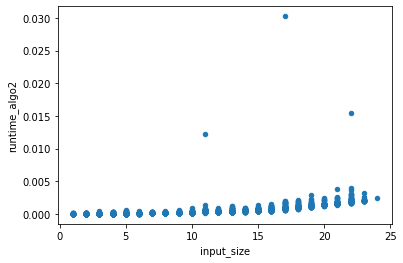

In [50]:
runtime = results[['input_size', 'runtime_algo1', 'runtime_algo2']]

plt.figure()
runtime.plot.scatter(x='input_size', y='runtime_algo1')
runtime.plot.scatter(x='input_size', y='runtime_algo2')

<AxesSubplot:xlabel='input_size', ylabel='cost_optsol'>

<Figure size 432x288 with 0 Axes>

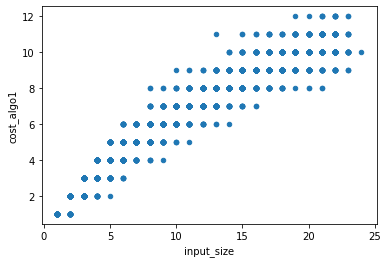

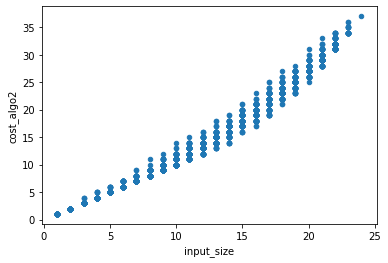

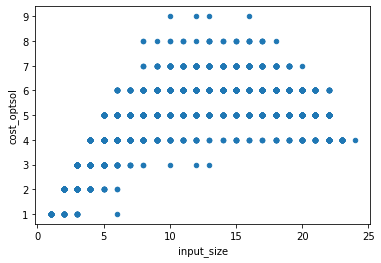

In [51]:
cost = results[['input_size', 'vertex_count', 'cost_algo1', 'cost_algo2', 'cost_optsol']]

plt.figure()
cost.plot.scatter(x='input_size', y='cost_algo1')
cost.plot.scatter(x='input_size', y='cost_algo2')
cost.plot.scatter(x='input_size', y='cost_optsol')

<AxesSubplot:xlabel='input_size', ylabel='num_rel_optsol'>

<Figure size 432x288 with 0 Axes>

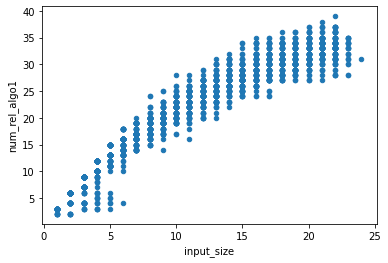

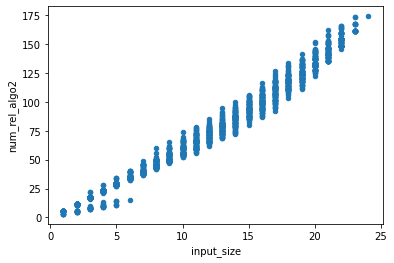

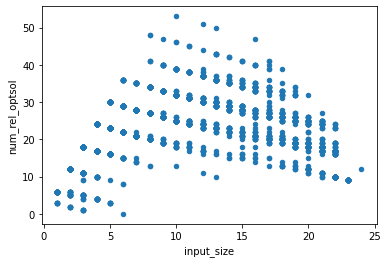

In [52]:
num_rel = results[['input_size', 'num_rel_algo1', 'num_rel_algo2', 'num_rel_optsol']]

plt.figure()
num_rel.plot.scatter(x='input_size', y='num_rel_algo1')
num_rel.plot.scatter(x='input_size', y='num_rel_algo2')
num_rel.plot.scatter(x='input_size', y='num_rel_optsol')

In [26]:
optapprox1 = results[results['cost_diff_algo1'] == 0]
optapprox1 = optapprox1[['input', 'output_algo1']]
print(optapprox1.shape)
optapprox1

(43, 2)


,input,output_algo1
0,"[1, 2, 3]","['[(1, 2), (2, 3)]']"
1,"[1, 3, 2]","['[(1, 3), (3, 2)]']"
2,"[2, 1, 3]","['[(1, 3), (2, 1)]']"
3,"[2, 3, 1]","['[(2, 3), (3, 1)]']"
4,"[3, 1, 2]","['[(1, 2), (3, 1)]']"
5,"[3, 2, 1]","['[(2, 1), (3, 2)]']"
6,"[1, 2, 3]-[1, 3, 2]","['[(1, 2), (1, 3)]']"
7,"[1, 2, 3]-[2, 1, 3]","['[(1, 3), (2, 3)]']"
8,"[1, 2, 3]-[2, 3, 1]","['[(1, 2), (2, 3)]', '[(2, 3), (3, 1)]']"
9,"[1, 2, 3]-[3, 1, 2]","['[(1, 2), (2, 3)]', '[(1, 2), (3, 1)]']"


In [35]:
notoptapprox1 = results[results['cost_diff_algo1'] != 0]
notoptapprox1 = notoptapprox1[['input', 'cost_diff_algo1', 'cost_algo1']]
print(notoptapprox1.describe())
notoptapprox1

(20, 3)
       cost_diff_algo1  cost_algo1
count        20.000000   20.000000
mean          1.050000    2.700000
std           0.223607    0.470162
min           1.000000    2.000000
25%           1.000000    2.000000
50%           1.000000    3.000000
75%           1.000000    3.000000
max           2.000000    3.000000


,input,cost_diff_algo1,cost_algo1
21,"[1, 2, 3]-[1, 3, 2]-[2, 1, 3]",1,2
23,"[1, 2, 3]-[1, 3, 2]-[3, 1, 2]",1,2
25,"[1, 2, 3]-[2, 1, 3]-[2, 3, 1]",1,2
36,"[1, 3, 2]-[3, 1, 2]-[3, 2, 1]",1,2
38,"[2, 1, 3]-[2, 3, 1]-[3, 2, 1]",1,2
40,"[2, 3, 1]-[3, 1, 2]-[3, 2, 1]",1,2
43,"[1, 2, 3]-[1, 3, 2]-[2, 1, 3]-[3, 2, 1]",1,3
44,"[1, 2, 3]-[1, 3, 2]-[2, 3, 1]-[3, 1, 2]",1,3
46,"[1, 2, 3]-[1, 3, 2]-[3, 1, 2]-[3, 2, 1]",1,3
47,"[1, 2, 3]-[2, 1, 3]-[2, 3, 1]-[3, 1, 2]",1,3


In [24]:
optapprox2 = results[results['cost_diff_algo2'] == 0]
optapprox2 = optapprox2[['input', 'output_algo2']]
print(optapprox2.shape)
optapprox2

(17, 2)


,input,output_algo2
0,"[1, 2, 3]","['[(1, 2), (1, 3), (2, 3)]']"
1,"[1, 3, 2]","['[(1, 2), (1, 3), (3, 2)]']"
2,"[2, 1, 3]","['[(1, 3), (2, 1), (2, 3)]']"
3,"[2, 3, 1]","['[(2, 1), (2, 3), (3, 1)]']"
4,"[3, 1, 2]","['[(1, 2), (3, 1), (3, 2)]']"
5,"[3, 2, 1]","['[(2, 1), (3, 1), (3, 2)]']"
8,"[1, 2, 3]-[2, 3, 1]","['[(1, 2), (1, 3), (2, 3)]', '[(2, 1), (2, 3), (3, 1)]']"
9,"[1, 2, 3]-[3, 1, 2]","['[(1, 2), (1, 3), (2, 3)]', '[(1, 2), (3, 1), (3, 2)]']"
10,"[1, 2, 3]-[3, 2, 1]","['[(1, 2), (1, 3), (2, 3)]', '[(2, 1), (3, 1), (3, 2)]']"
11,"[1, 3, 2]-[2, 1, 3]","['[(1, 2), (1, 3), (3, 2)]', '[(1, 3), (2, 1), (2, 3)]']"


In [37]:
notoptapprox2 = results[results['cost_diff_algo2'] != 0]
notoptapprox2 = notoptapprox2[['input', 'cost_diff_algo2', 'cost_algo2']]
print(notoptapprox2.describe())
notoptapprox2

       cost_diff_algo2  cost_algo2
count        46.000000   46.000000
mean          1.978261    3.695652
std           1.085032    1.190137
min           1.000000    2.000000
25%           1.000000    3.000000
50%           2.000000    3.500000
75%           2.000000    4.000000
max           6.000000    7.000000


,input,cost_diff_algo2,cost_algo2
6,"[1, 2, 3]-[1, 3, 2]",1,2
7,"[1, 2, 3]-[2, 1, 3]",1,2
13,"[1, 3, 2]-[3, 1, 2]",1,2
15,"[2, 1, 3]-[2, 3, 1]",1,2
19,"[2, 3, 1]-[3, 2, 1]",1,2
20,"[3, 1, 2]-[3, 2, 1]",1,2
21,"[1, 2, 3]-[1, 3, 2]-[2, 1, 3]",3,4
22,"[1, 2, 3]-[1, 3, 2]-[2, 3, 1]",1,3
23,"[1, 2, 3]-[1, 3, 2]-[3, 1, 2]",2,3
24,"[1, 2, 3]-[1, 3, 2]-[3, 2, 1]",1,3


In [38]:
optapprox = results[results['cost_algo1'] == results['cost_algo2']]
optapprox = optapprox[['input', 'output_algo1', 'output_algo2']]
print(optapprox.describe())
optapprox

            input          output_algo1                  output_algo2
count          17                    17                            17
unique         17                    17                            17
top     [1, 2, 3]  ['[(1, 2), (2, 3)]']  ['[(1, 2), (1, 3), (2, 3)]']
freq            1                     1                             1


,input,output_algo1,output_algo2
0,"[1, 2, 3]","['[(1, 2), (2, 3)]']","['[(1, 2), (1, 3), (2, 3)]']"
1,"[1, 3, 2]","['[(1, 3), (3, 2)]']","['[(1, 2), (1, 3), (3, 2)]']"
2,"[2, 1, 3]","['[(1, 3), (2, 1)]']","['[(1, 3), (2, 1), (2, 3)]']"
3,"[2, 3, 1]","['[(2, 3), (3, 1)]']","['[(2, 1), (2, 3), (3, 1)]']"
4,"[3, 1, 2]","['[(1, 2), (3, 1)]']","['[(1, 2), (3, 1), (3, 2)]']"
5,"[3, 2, 1]","['[(2, 1), (3, 2)]']","['[(2, 1), (3, 1), (3, 2)]']"
8,"[1, 2, 3]-[2, 3, 1]","['[(1, 2), (2, 3)]', '[(2, 3), (3, 1)]']","['[(1, 2), (1, 3), (2, 3)]', '[(2, 1), (2, 3), (3, 1)]']"
9,"[1, 2, 3]-[3, 1, 2]","['[(1, 2), (2, 3)]', '[(1, 2), (3, 1)]']","['[(1, 2), (1, 3), (2, 3)]', '[(1, 2), (3, 1), (3, 2)]']"
10,"[1, 2, 3]-[3, 2, 1]","['[(1, 2), (2, 3)]', '[(2, 1), (3, 2)]']","['[(1, 2), (1, 3), (2, 3)]', '[(2, 1), (3, 1), (3, 2)]']"
11,"[1, 3, 2]-[2, 1, 3]","['[(1, 3), (3, 2)]', '[(1, 3), (2, 1)]']","['[(1, 2), (1, 3), (3, 2)]', '[(1, 3), (2, 1), (2, 3)]']"


In [44]:
optapprox_joined = pd.merge(optapprox1, optapprox2, how='outer')
optapprox_joined

,input,output_algo1,output_algo2
0,"[1, 2, 3]","['[(1, 2), (2, 3)]']","['[(1, 2), (1, 3), (2, 3)]']"
1,"[1, 3, 2]","['[(1, 3), (3, 2)]']","['[(1, 2), (1, 3), (3, 2)]']"
2,"[2, 1, 3]","['[(1, 3), (2, 1)]']","['[(1, 3), (2, 1), (2, 3)]']"
3,"[2, 3, 1]","['[(2, 3), (3, 1)]']","['[(2, 1), (2, 3), (3, 1)]']"
4,"[3, 1, 2]","['[(1, 2), (3, 1)]']","['[(1, 2), (3, 1), (3, 2)]']"
5,"[3, 2, 1]","['[(2, 1), (3, 2)]']","['[(2, 1), (3, 1), (3, 2)]']"
6,"[1, 2, 3]-[1, 3, 2]","['[(1, 2), (1, 3)]']",NaN
7,"[1, 2, 3]-[2, 1, 3]","['[(1, 3), (2, 3)]']",NaN
8,"[1, 2, 3]-[2, 3, 1]","['[(1, 2), (2, 3)]', '[(2, 3), (3, 1)]']","['[(1, 2), (1, 3), (2, 3)]', '[(2, 1), (2, 3), (3, 1)]']"
9,"[1, 2, 3]-[3, 1, 2]","['[(1, 2), (2, 3)]', '[(1, 2), (3, 1)]']","['[(1, 2), (1, 3), (2, 3)]', '[(1, 2), (3, 1), (3, 2)]']"
